### Churn prediction 

#### Data preparation

In [1]:
# Import the necessary dependency
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'

In [3]:
df = pd.read_csv(url)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

c:\Users\oluwa\.conda\envs\ml-zoomcamp\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

### Accuracy and dummy model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [8]:
len(y_val)

1409

In [9]:
(y_val == churn_decision).sum()

1132

In [10]:
1132 / 1409

0.8034066713981547

In [11]:
(y_val == churn_decision).mean()

0.8034066713981547

In [12]:
threshold = np.linspace(0, 1, 21)

scores = []
for i in threshold:
    churn_decision = (y_pred >= i)
    score = (y_val == churn_decision).mean()
    print(f"{i:.2f} {score:.3f}")
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


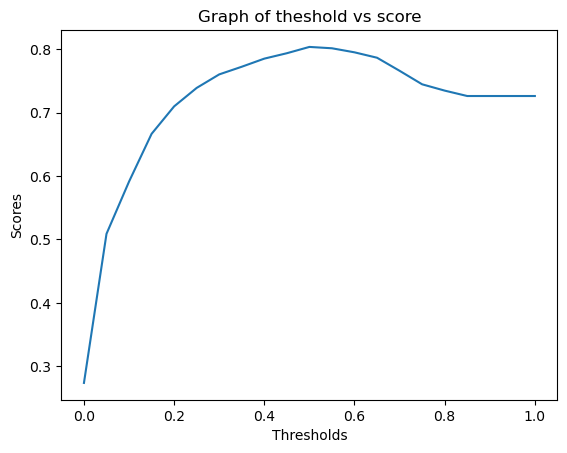

In [13]:
plt.plot(threshold, scores)
plt.xlabel("Thresholds")
plt.ylabel("Scores")
plt.title("Graph of theshold vs score");

In [14]:
from sklearn.metrics import accuracy_score

In [15]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [16]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print(f"{t:.2f} {score:.3f}")
    scores.append(score)

0.00 0.274
0.05 0.509
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.772
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.766
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


In [17]:
from collections import Counter 

In [18]:
print(f"% churning: {y_val.mean()}")
print(f"% non-churning: {1 - y_val.mean()}")

% churning: 0.2739531582682754
% non-churning: 0.7260468417317246


In [19]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [20]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

### Confusion table

- Different types of errors and correct decisions
- Arranging them in a table

In [21]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [22]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [23]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [24]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [25]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

### Precision and Recall

In [26]:
# accuracy can also be defined as sum of tp and tn / total number

(tp + tn) / (tp + tn + fp + fn)

0.8034066713981547

#### Precision tell us among the positive prediction what fraction are correct

$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

In [27]:
precision = tp / (tp + fp)

precision

0.6752411575562701

#### Recall is the fraction of correctly identified positive examples

$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

In [28]:
recall = tp / (tp + fn)

recall

0.5440414507772021

### ROC Curves
ROC - Receiver Operating Characteristics

TPR - True Positive Rate

$$
\text{TPR} = \frac{\text{TP}}{\text{FN} + \text{TP}}
$$

FPR - False Positive Rate

$$
\text{FPR} = \frac{\text{FP}}{\text{TN} + \text{FP}}
$$

In [30]:
tpr = tp / (tp + fn) 

tpr

0.5440414507772021

In [32]:
fpr = fp / (tn + fp)

fpr

0.09872922776148582

In [37]:
thresholds = np.linspace(0, 1, 101)

scores = []
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))


In [45]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']

df_scores  = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)

In [46]:
df_scores[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,20,467,0.948187,0.543500
20,0.2,333,356,53,667,0.862694,0.347996
30,0.3,284,236,102,787,0.735751,0.230694
40,0.4,249,166,137,857,0.645078,0.162268
50,0.5,210,101,176,922,0.544041,0.098729
60,0.6,150,53,236,970,0.388601,0.051808
70,0.7,76,20,310,1003,0.196891,0.019550
80,0.8,13,1,373,1022,0.033679,0.000978
90,0.9,0,0,386,1023,0.000000,0.000000


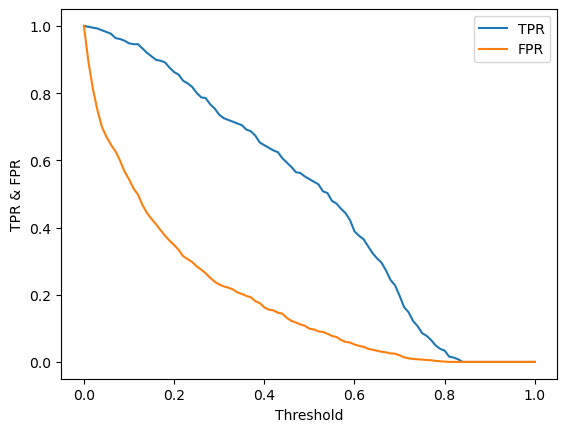

In [50]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores["fpr"], label= "FPR")
plt.xlabel("Threshold")
plt.ylabel("TPR & FPR")
plt.legend();

### Random model

In [52]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1 ,size=len(y_val))

In [53]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [60]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
    
    return df_scores

In [61]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

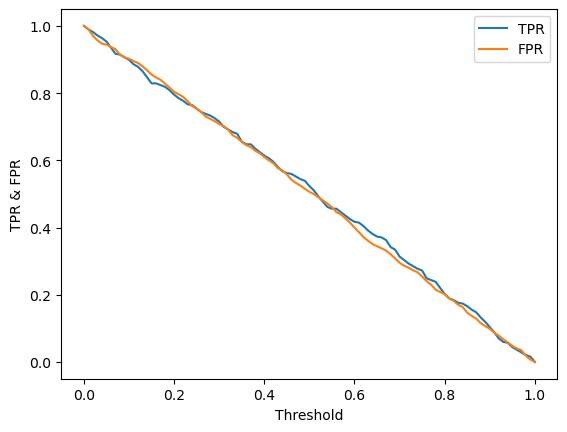

In [62]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.xlabel("Threshold")
plt.ylabel("TPR & FPR")
plt.legend();

### Ideal model

In [63]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

In [65]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])
y_ideal

y_ideal_pred = np.linspace(0, 1, len(y_val))

In [67]:
1 - y_val.mean()

0.7260468417317246

In [66]:
accuracy_score(y_ideal, y_ideal_pred >= 0.726)

1.0

In [68]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,0,141,1.000000,0.862170
20,0.2,386,741,0,282,1.000000,0.724340
30,0.3,386,600,0,423,1.000000,0.586510
40,0.4,386,459,0,564,1.000000,0.448680
50,0.5,386,319,0,704,1.000000,0.311828
60,0.6,386,178,0,845,1.000000,0.173998
70,0.7,386,37,0,986,1.000000,0.036168
80,0.8,282,0,104,1023,0.730570,0.000000
90,0.9,141,0,245,1023,0.365285,0.000000


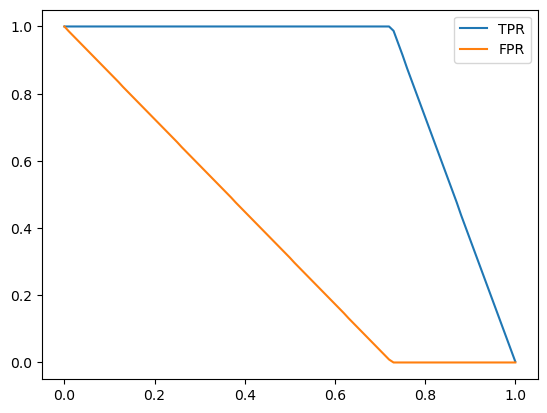

In [70]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend();

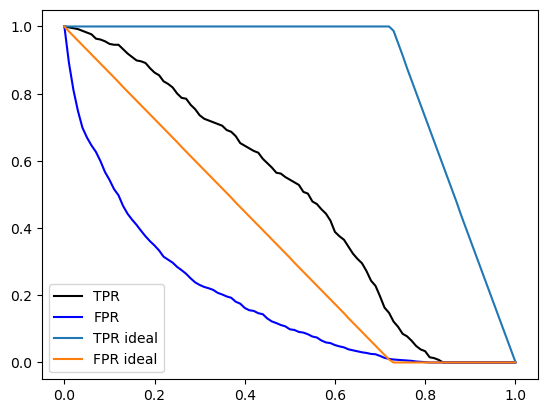

In [73]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend();

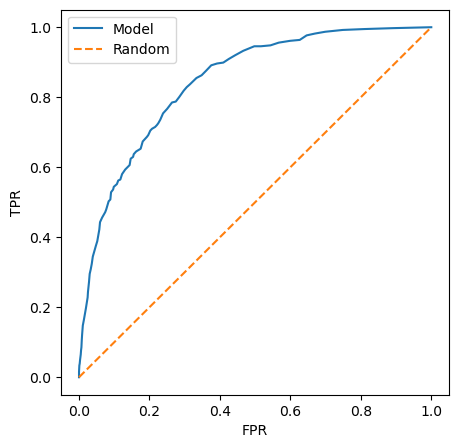

In [75]:
plt.figure(figsize=(5, 5))

plt.plot(df_scores.fpr, df_scores.tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

In [79]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_val, y_pred)

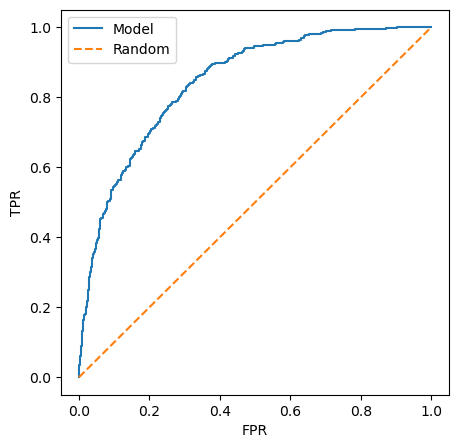

In [78]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend();

### ROC AUC

- Area under the ROC curve - useful metric
- Interpretation of AUC(tells us the probabilty that a randomly selected positive example has a score that is higher than the random negative example)

In [81]:
from sklearn.metrics import auc

In [83]:
auc(fpr, tpr)

0.8438302463039217

In [84]:
auc(df_scores.fpr, df_scores.tpr)

0.8438986218528255

In [86]:
auc(df_ideal.fpr, df_ideal.tpr)

0.9999430203759136

In [87]:
from sklearn.metrics import roc_auc_score

In [89]:
roc_auc_score(y_val, y_pred)

0.8438302463039217

In [90]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [95]:
import random

n = 100000
success = 0

for i in range(n):
    pos_ind = random.randint(0, len(pos)-1)
    neg_ind = random.randint(0, len(neg)-1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1
        
success / n

0.846

In [96]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.84646

### Cross validation
- Evaluating the same model on different subset of data
- Getting the average prediction and the spread within predictions

In [123]:
def train(df, y, C=1.0):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=5000)
    model.fit(X_train, y)
    
    return dv, model

In [121]:
len(X_train), len(y_train)

(4225, 4508)

In [99]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred

In [100]:
y_pred = predict(df_val, dv, model)

In [101]:
from sklearn.model_selection import KFold

In [102]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [105]:
train_idx , val_idx = next(kfold.split(df_full_train))

In [107]:
len(train_idx), len(val_idx), len(df_full_train)

(5070, 564, 5634)

In [110]:
from tqdm.auto import tqdm

In [118]:
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.825 +- 0.009
C=0.01 0.840 +- 0.008
C=0.1 0.842 +- 0.007
C=0.5 0.842 +- 0.007
C=1 0.842 +- 0.007
C=5 0.842 +- 0.007
C=10 0.842 +- 0.007


In [124]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8584194589792756